# Mask Detection – Preprocessing, Split (8-1-1) and Training with MobileNetV2

## 1. Import libraries

In [1]:

import os
import random
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
import kagglehub





2025-12-19 15:19:19.183871: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 15:19:19.202148: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 15:19:19.900979: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 15:19:21.985631: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

In [2]:
# Directory paths
data_dir = "./data"
raw_data_dir = "./data"
input_dir = "./data"
output_dir = "./split_data"
split_dir = output_dir
processed_dir = "./pre_train"
train_dir = "./pre_train/train"
val_dir = "./pre_train/val"
test_dir = "./pre_train/test"

# Model paths
face_detector_proto = "models/deploy.prototxt"
face_detector_model = "models/res10_300x300_ssd_iter_140000.caffemodel"

# Image processing configurations
image_size = (224, 224)
classes = ("with_mask", "without_mask")
num_images = 3

# Data split ratios
splits = {"train": 0.8, "val": 0.1, "test": 0.1}

# Training parameters
batch_size = 32
epochs = 10

In [3]:
import os
import shutil
import kagglehub

data_dir = "data"

if not os.path.exists(data_dir):
    path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

    inner_data = os.path.join(path, "data")

    shutil.copytree(inner_data, data_dir)

    print("Dataset copy vào thư mục data/")
else:
    print("Dataset đã tồn tại")


Dataset đã tồn tại


## 3. Function to show sample images

In [4]:

def show_samples(data_dir, classes=("with_mask", "without_mask"), num_images=3):
    plt.figure(figsize=(12, 6))
    idx = 1

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        images = [
            f for f in os.listdir(cls_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ][:num_images]

        for img_name in images:
            img = Image.open(os.path.join(cls_dir, img_name)).convert("RGB")
            plt.subplot(len(classes), num_images, idx)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            idx += 1

    plt.show()


## 4. Show images after unzip

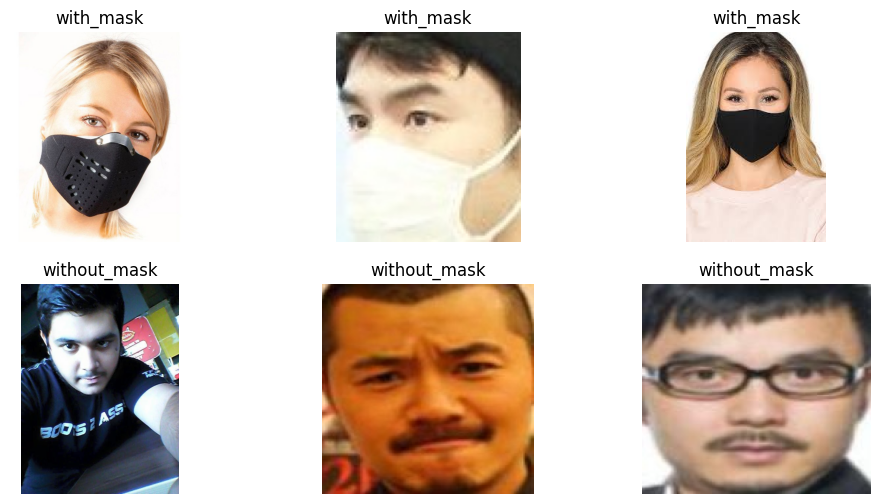

In [5]:

show_samples(raw_data_dir)


## 5. Split data (8-1-1)

In [6]:

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * splits["train"])
    n_val = int(n_total * splits["val"])

    split_dict = {
        "train": images[:n_train],
        "val": images[n_train:n_train + n_val],
        "test": images[n_train + n_val:]
    }

    for split, split_images in split_dict.items():
        split_cls_dir = os.path.join(output_dir, split, cls)
        os.makedirs(split_cls_dir, exist_ok=True)

        for img in split_images:
            shutil.copy(
                os.path.join(cls_path, img),
                os.path.join(split_cls_dir, img)
            )


## 6. Show images after split (train set)

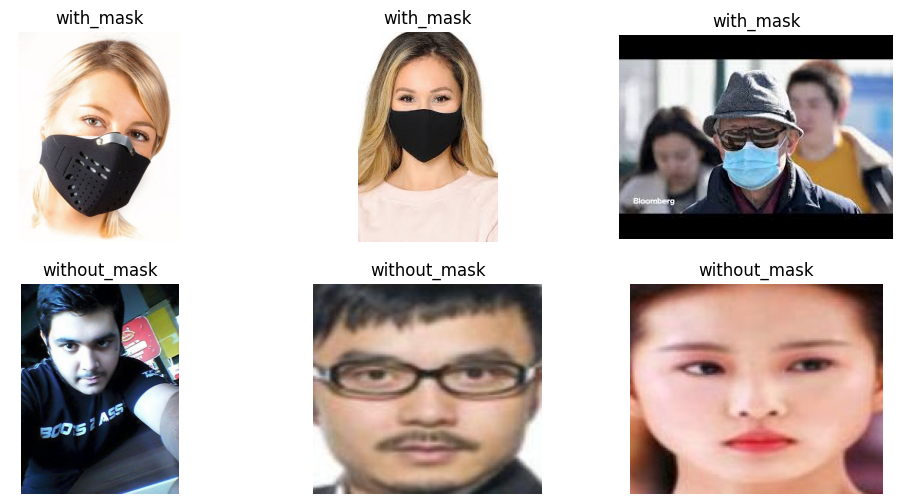

In [7]:

show_samples("./split_data/train")


## 7.  preprocessing

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import hashlib
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

os.makedirs(processed_dir, exist_ok=True)

hashes = set()

def is_duplicate(img_array):
    h = hashlib.md5(img_array.tobytes()).hexdigest()
    if h in hashes:
        return True
    hashes.add(h)
    return False

for root, dirs, files in os.walk(split_dir):
    # giữ nguyên cấu trúc thư mục
    relative_path = os.path.relpath(root, split_dir)
    output_root = os.path.join(processed_dir, relative_path)
    os.makedirs(output_root, exist_ok=True)

    for file in files:
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        img_path = os.path.join(root, file)

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)

        img_array = np.array(img).astype("float32")

        if is_duplicate(img_array):
            continue

        img_array = preprocess_input(img_array)

        img_save = Image.fromarray(
            ((img_array + 1) / 2 * 255).astype("uint8")
        )

        img_save.save(os.path.join(output_root, file))

## 8. Show after preprocess

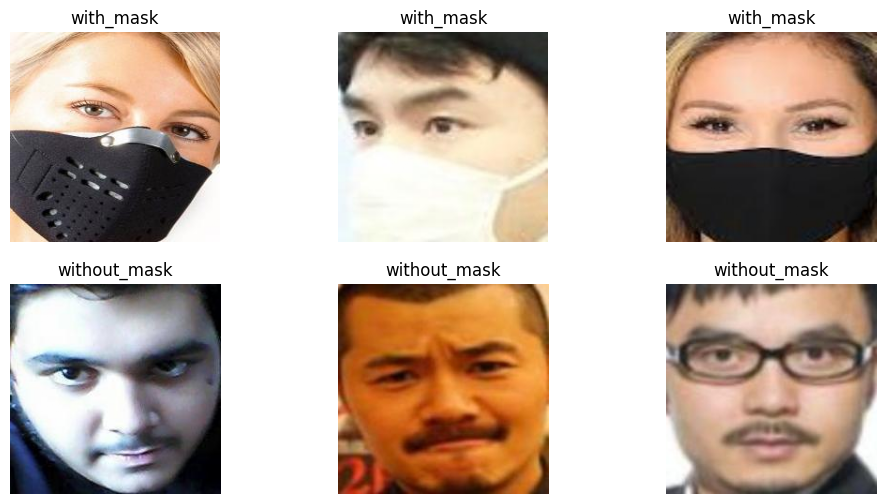

In [9]:
classes = ("with_mask", "without_mask")
num_images = 3
plt.figure(figsize=(12, 6))
idx = 1
show = f"{processed_dir}/train"
for cls in classes:
    cls_dir = os.path.join(show, cls)
    images = [
        f for f in os.listdir(cls_dir)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ][:num_images]

    for img_name in images:
        img = Image.open(os.path.join(cls_dir, img_name)).convert("RGB")
        img = np.array(img).astype("float32") / 255.0
        plt.subplot(len(classes), num_images, idx)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        idx += 1

plt.show()

## 9. Load data for MobileNetV2

In [10]:

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


Found 6883 images belonging to 2 classes.
Found 1940 images belonging to 2 classes.
Found 1957 images belonging to 2 classes.


## 10. Build MobileNetV2 model

In [11]:

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


2025-12-19 15:21:57.701394: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 11. Train model

In [13]:

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 71s 329ms/step - accuracy: 0.9945 - loss: 0.0226 - val_accuracy: 0.9964 - val_loss: 0.0139
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 68s 313ms/step - accuracy: 0.9962 - loss: 0.0133 - val_accuracy: 0.9969 - val_loss: 0.0146
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 71s 327ms/step - accuracy: 0.9975 - loss: 0.0091 - val_accuracy: 0.9974 - val_loss: 0.0104
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 71s 326ms/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 0.9979 - val_loss: 0.0055
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 70s 325ms/step - accuracy: 0.9984 - loss: 0.0056 - val_accuracy: 0.9990 - val_loss: 0.0040
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 69s 321ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9995 - val_loss: 0.0016
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 74s 342ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 71s 329ms/step - accuracy: 1.0000 - loss: 7

## 12. Evaluate on test set and save

In [ ]:

model.evaluate(test_gen)
model.save("mask_mobilenet_no_face_cut.h5")



62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 1.0000 - loss: 1.2820e-04


## 13. Draw loss & acc

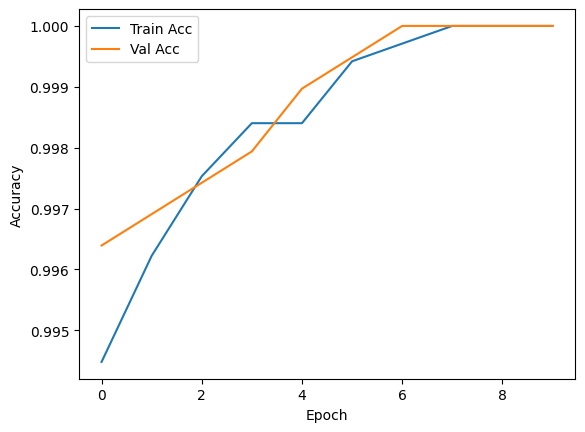

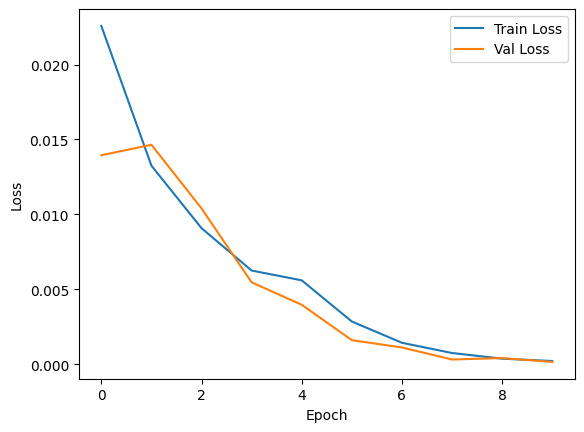

In [15]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
